## Load functions and data

In [1]:
# Enable autoreload extension to automatically reload modules
%load_ext autoreload
%autoreload 1

# Import necessary modules and libraries
from AirSeaFluxCode import AirSeaFluxCode  # Import AirSeaFluxCode class from AirSeaFluxCode module
import xarray as xr  # Import xarray library with alias xr
import gsw_xarray as gsw  # Import gsw_xarray module with alias gsw
import matplotlib.dates as mdates  # Import module for working with dates in matplotlib
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy library with alias np for numerical operations
import cartopy.crs as ccrs  # Import cartopy for geospatial data visualization
import cmocean.cm as cmo  # Import colormaps from cmocean for oceanography
from matplotlib.lines import Line2D
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter

# Import my_funcs module for interactive reloading
%aimport my_funcs

# Call update_params function from my_funcs module to update parameters
my_funcs.update_params(fontsize=24)

# Define a function to customize x-axis ticks on a plot
def fix_xticks(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to display month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Format major ticks as abbreviated month (e.g., Jan)
    # Set x-axis label to '2019'
    ax.set_xlabel('2019')

# Define color variables with hexadecimal color codes
c20 = "#C13F89"  # Define color c20
c22 = "#3ec177"  # Define color c22
c23 = "#3e88c1"  # Define color c23
ext = "#a43ec1"  # Define color ext

# Manually create Line2D objects for legend handles
legend_handles = [
    Line2D([], [], color=c20, lw=3, label='SD1020'),
    Line2D([], [], color=c22, lw=3, label='SD1022'),
    Line2D([], [], color=c23, lw=3, label='SD1023')
]

In [48]:
# Load SD1020 ADCP and dataset, squeeze and swap dimensions
adcp = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc')\
        .squeeze().swap_dims({'obs':'time'})
ds20 = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc')\
        .squeeze().swap_dims({'obs':'time'})

# Load SD1022 and SD1023 datasets, and set coordinates
ds22 = xr.open_dataset('../data/Sd1022_data_merged.nc').set_coords(['longitude','latitude'])
ds23 = xr.open_dataset('../data/Sd1023_data_merged.nc').set_coords(['longitude','latitude'])

#ds20["lon"] = ('time'), ((ds20.longitude + 360) % 360).values
#ds22["lon"] = ('time'), ((ds22.longitude + 360) % 360).values
#ds23["lon"] = ('time'), ((ds23.longitude + 360) % 360).values

ds20 = ds20.isel(time=slice(0,95630)).interpolate_na('time')
ds22 = ds22.isel(time=slice(0,137268)).interpolate_na('time')
ds23 = ds23.isel(time=slice(0,99996)).interpolate_na('time')

## Calculate wind speed and air-sea fluxes

In [49]:
def calc_ws_wd(ds):
    """
    Calculates wind speed and wind direction from zonal (UWND_MEAN) and meridional (VWND_MEAN) wind components.

    Parameters:
    - ds (xarray.Dataset): Dataset containing zonal and meridional wind components.

    Returns:
    - ds (xarray.Dataset): Dataset with the calculated wind speed and wind direction added as new variables 'wind_speed' and 'wind_direction'.
    """
    # Calculate wind speed using the square root of the sum of squares of zonal and meridional wind components
    ds['wind_speed'] = np.sqrt(ds['UWND_MEAN']**2 + ds['VWND_MEAN']**2)

    # Calculate wind direction using arctan2 function
    ds['wind_direction'] = np.arctan2(ds['VWND_MEAN'], ds['UWND_MEAN']) * (180 / np.pi)
    ds['wind_direction'] = (ds['wind_direction'] + 360) % 360  # Convert negative angles to positive
    
    return ds

In [50]:
# Calculate wind speed and wind direction for SD1020 dataset
ds20 = calc_ws_wd(ds20)

# Calculate wind speed and wind direction for SD1022 dataset
ds22 = calc_ws_wd(ds22)

# Calculate wind speed and wind direction for SD1023 dataset
ds23 = calc_ws_wd(ds23)

In [51]:
def calc_tasf(ds,SST):

        # Convert ship data into NumPy arrays
    lat  = np.asarray(ds["latitude"])              # Latitude
    spd  = np.asarray(ds["wind_speed"])            # Wind speed
    t    = np.asarray(ds["TEMP_AIR_MEAN"])         # Air temperature
    sst  = np.asarray(ds[SST])                     # Sea surface temperature
    rh   = np.asarray(ds["RH_MEAN"])               # Relative humidity
    
    # Initialize a constant
    hin  = 17  # Height of the sensors (17 meters)
    
    # Calculate temperature at 2 meters above the sea surface ('t10n') and relative and specific humidity at 2 meters above the sea surface ('rh','q10n')
    
    air_hum = AirSeaFluxCode(spd, 
                             t, 
                             sst, 
                             "skin", 
                             meth = "C35", 
                             lat = lat, 
                             hin = [3.68,2.5,2.5], 
                             hout = 10,
                             hum=["rh", rh], 
                             out_var = ["tref","rh", "qref",'qair','qsea',"uref",'latent','sensible'])
    
    # # Calculate horizontal wind speed at 10 meters above the sea surface ('u10n')
    # wind = AirSeaFluxCode(spd, 
    #                       t, 
    #                       sst, 
    #                       "skin", 
    #                       meth = "C35", 
    #                       lat = lat, 
    #                       hin = [3.68,2.5,2.5], 
    #                       hout = 10,
    #                       out_var = ["uref",'latent','sensible'])
    
    
    
    # Assign the calculated temperature values (converted to degrees Celsius) at 2 meters above the sea surface to the 't2m' column
    ds['t2m'] = ('time'), air_hum['tref'] - 273.15
    
    # Assign the calculated horizontal wind speed values at 10 meters above the sea surface to the 'u10' column
    ds['u10'] = ('time'), air_hum['uref']
    
    # Assign the calculated specific humidity values at 2 meters above the sea surface (converted to g/kg) to the 'qref' column
    ds['rh_corr'] = ('time'), air_hum['rh']
    ds['qref'] = ('time'), air_hum['qref']*1000
    ds['qair'] = ('time'), air_hum['qair']*1000
    ds['qsea'] = ('time'), air_hum['qsea']*1000
    
    # Assign some flags or indicators to the 'flags' column
    ds['flags'] = ('time'), air_hum['flag']
    
    # Assign some flags or indicators to the 'flags' column
    ds['sensible'] = ('time'), air_hum['sensible']
    ds['latent'] = ('time'), air_hum['latent']

    return ds

In [52]:
ds20 = calc_tasf(ds20,"TEMP_CTD_RBR_MEAN")
ds22 = calc_tasf(ds22,"TEMP_CTD_RBR_MEAN")
ds23 = calc_tasf(ds23,"TEMP_CTD_RBR_MEAN")

In [84]:
def drop_vars(ds):
    # List comprehension to filter out variables ending with "_STDDEV"
    var_to_save = [var for var in list(ds20.reset_coords().keys()) if not var.endswith('_STDDEV') and "trajectory" not in var]
    var_to_save = [var for var in var_to_save if "O2" not in var and "CHLOR" not in var and "WAVE" not in var]
    var_to_save = [var for var in var_to_save if "UWND" not in var and "VWND" not in var and "WWND" not in var]
    var_to_save = [var for var in var_to_save if "HDG_WING" not in var and "WING_ANGLE" not in var and "WIND" not in var]
    var_to_save = [var for var in var_to_save if "flags" not in var]
    # var_to_save_filtered will contain all variables from var_to_save except those ending with "_STDDEV"
    ds = ds[var_to_save]
    return ds

In [58]:
ds20 = drop_vars(ds20)
ds22 = drop_vars(ds22)
ds23 = drop_vars(ds23)

## Histograms of turbulent heat fluxes from a time series

Let's have a look a the distribution before binning

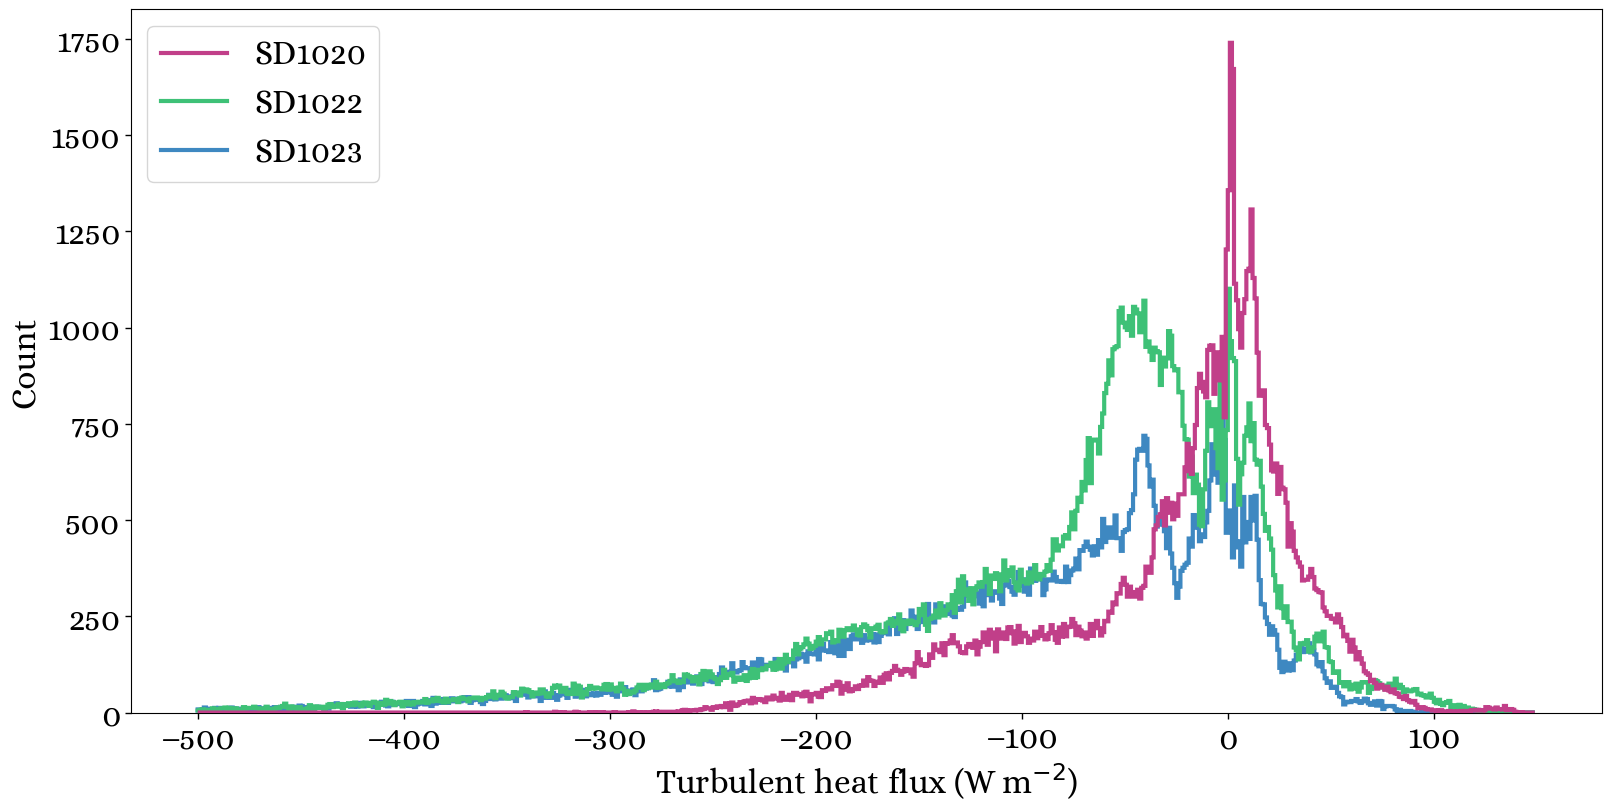

In [127]:
fig,ax = plt.subplots(figsize=(32/2,16/2),constrained_layout=True)

_=ax.hist(ds20['latent'] + ds20['sensible'],ec=c20,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=3, density=False)
_=ax.hist(ds22['latent'] + ds22['sensible'],ec=c22,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=2, density=False)
_=ax.hist(ds23['latent'] + ds23['sensible'],ec=c23,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=1, density=False)

ax.legend(handles=legend_handles, loc='upper left',ncols=1)
ax.set(ylabel='Count', xlabel="Turbulent heat flux (W m$^{-2}$)")
#plt.yscale('log')
plt.show()

In [128]:
(ds205['sensible'] + ds205['latent']).std()

<xarray.DataArray ()>
array(64.0331924)

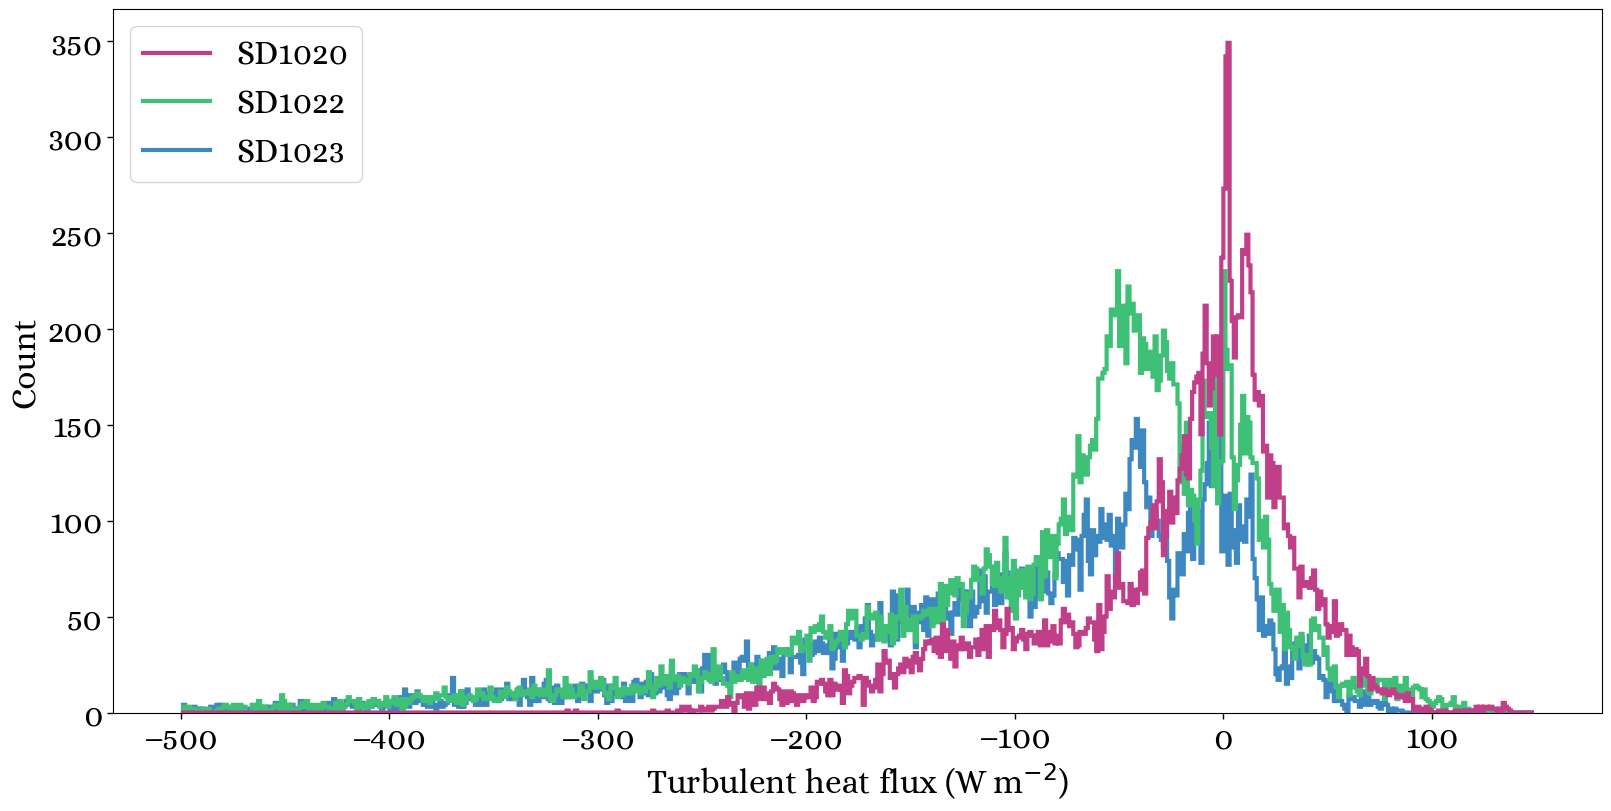

In [129]:
fig,ax = plt.subplots(figsize=(32/2,16/2),constrained_layout=True)

_=ax.hist(ds205['latent'] + ds205['sensible'],ec=c20,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=3, density=False)
_=ax.hist(ds225['latent'] + ds225['sensible'],ec=c22,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=2, density=False)
_=ax.hist(ds235['latent'] + ds235['sensible'],ec=c23,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=1, density=False)

ax.legend(handles=legend_handles, loc='upper left',ncols=1)
ax.set(ylabel='Count', xlabel="Turbulent heat flux (W m$^{-2}$)")
#plt.yscale('log')
plt.show()

In [61]:
ds205 = ds20.reset_coords().resample(time="5min").mean("time")
ds225 = ds22.reset_coords().resample(time="5min").mean("time")
ds235 = ds23.reset_coords().resample(time="5min").mean("time")

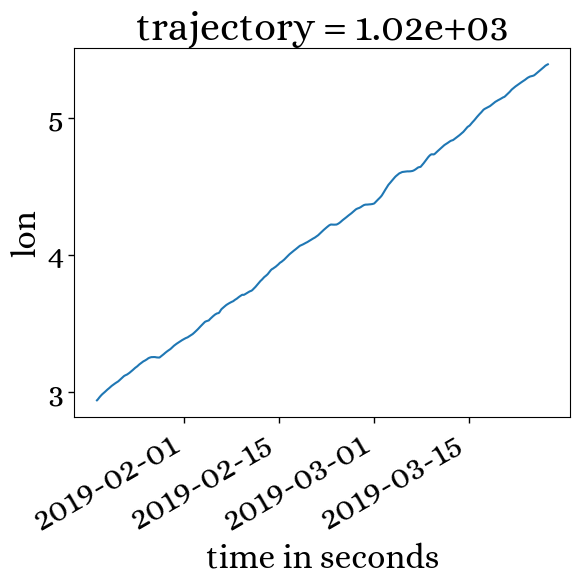

In [167]:
(np.deg2rad(ds20['lon'])).plot()
plt.show()

In [62]:
ds205['distance'] = ('time'), np.cumsum(np.insert(gsw.distance(ds205['lon'].interpolate_na('time'),
                                                              ds205['latitude'].interpolate_na('time')),0,0))

ds225['distance'] = ('time'), np.cumsum(np.insert(gsw.distance(ds225['lon'].interpolate_na('time'),
                                                              ds225['latitude'].interpolate_na('time')),0,0))

ds235['distance'] = ('time'), np.cumsum(np.insert(gsw.distance(ds235['lon'].interpolate_na('time'),
                                                              ds235['latitude'].interpolate_na('time')),0,0))

In [87]:
ds205.to_netcdf("../data/sd1020_5min.nc")
ds225.to_netcdf("../data/sd1022_5min.nc")
ds235.to_netcdf("../data/sd1023_5min.nc")

In [81]:
dist205 = ds205.swap_dims({"time":"distance"}).interp(distance=np.arange(0,ds205['distance'].max().values+1,1000))
dist225 = ds225.swap_dims({"time":"distance"}).interp(distance=np.arange(0,ds225['distance'].max().values+1,1000))
dist235 = ds235.swap_dims({"time":"distance"}).interp(distance=np.arange(0,ds235['distance'].max().values+1,1000))

In [92]:
dist205["tasf"] = ('distance'), dist205['latent'].values + dist205['sensible'].values
dist225["tasf"] = ('distance'), dist225['latent'].values + dist225['sensible'].values
dist235["tasf"] = ('distance'), dist235['latent'].values + dist235['sensible'].values

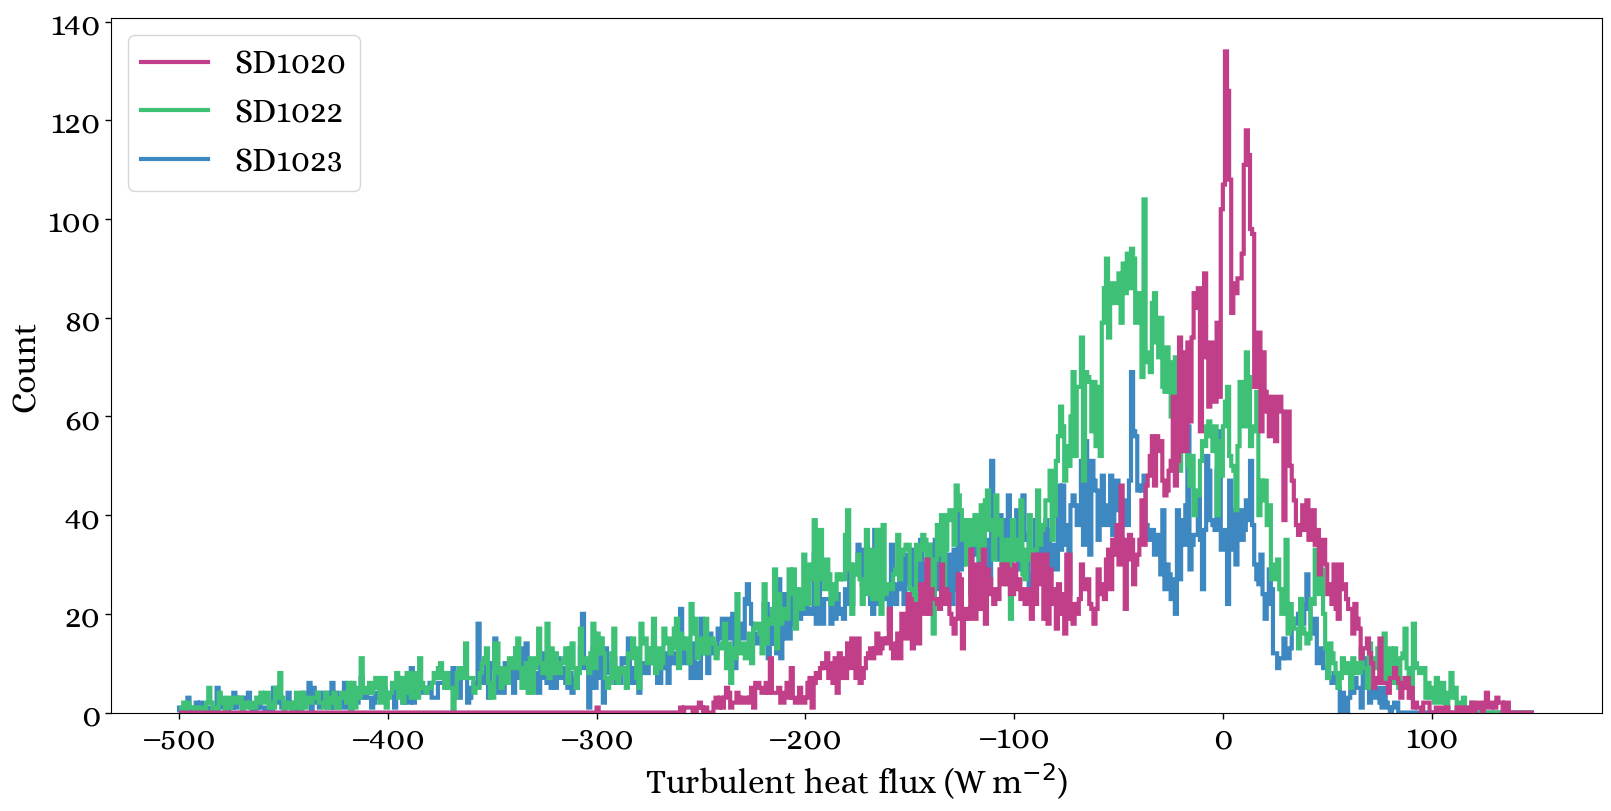

In [131]:
fig,ax = plt.subplots(figsize=(32/2,16/2),constrained_layout=True)

_=ax.hist(dist205['tasf'],ec=c20,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=3, density=False)
_=ax.hist(dist225['tasf'],ec=c22,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=2, density=False)
_=ax.hist(dist235['tasf'],ec=c23,histtype='step',lw=3, bins=np.arange(-500,150,1),zorder=1, density=False)

ax.legend(handles=legend_handles, loc='upper left',ncols=1)
ax.set(ylabel='Count', xlabel="Turbulent heat flux (W m$^{-2}$)")
#plt.yscale('log')
plt.show()

In [112]:
dist205.to_netcdf("../data/sd1020_5min_1km.nc")
dist225.to_netcdf("../data/sd1022_5min_1km.nc")
dist235.to_netcdf("../data/sd1023_5min_1km.nc")

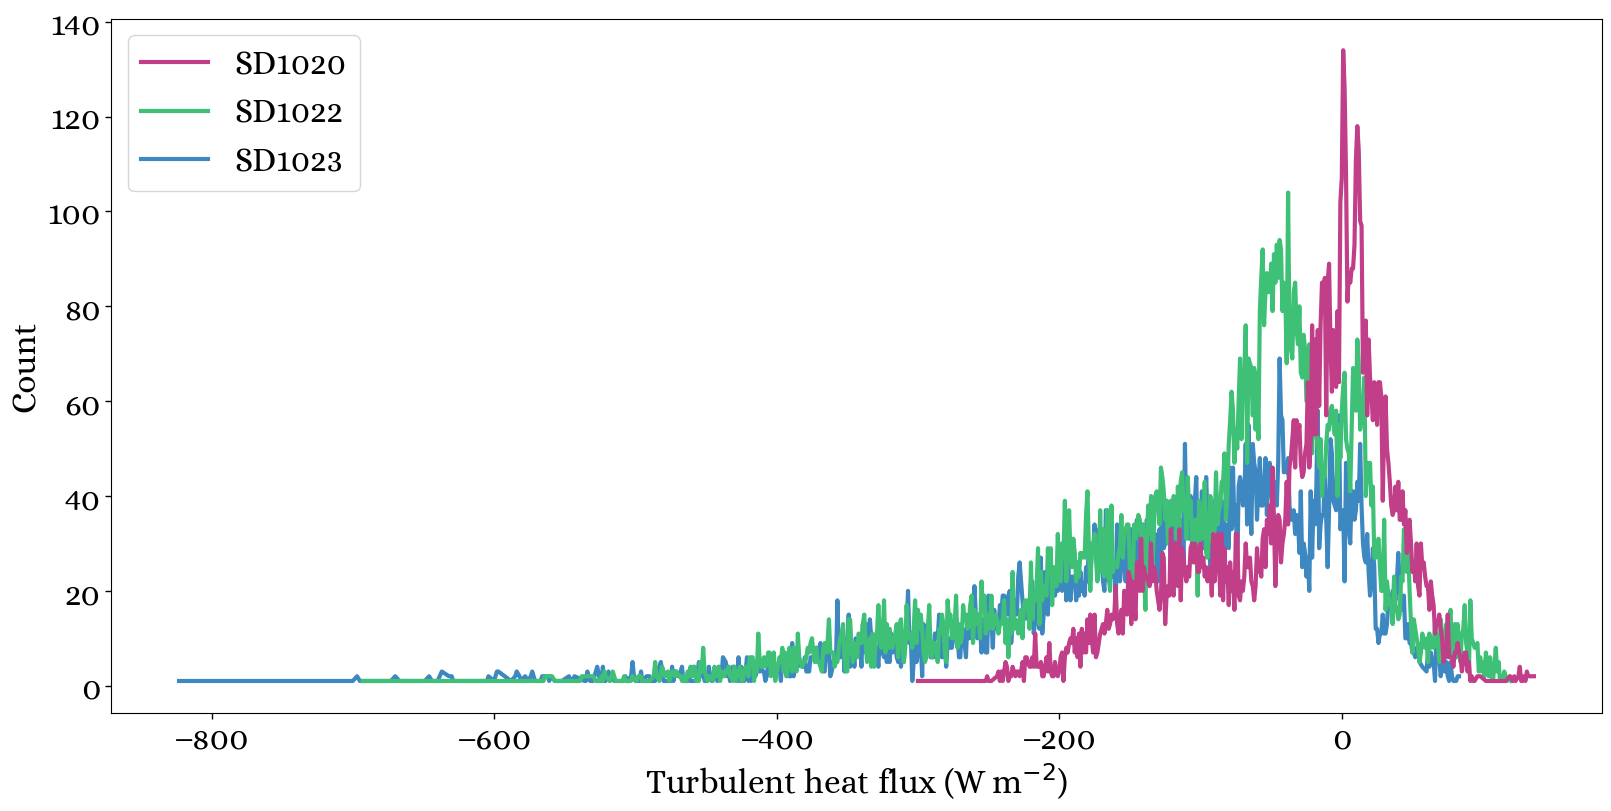

In [111]:
fig, ax = plt.subplots(figsize=(32/2,16/2),constrained_layout=True)

# Calculate histograms
hist205, bins = np.histogram(dist205['tasf'], bins=np.arange(-1000,150,1))
hist225, _ = np.histogram(dist225['tasf'], bins=np.arange(-1000,150,1))
hist235, _ = np.histogram(dist235['tasf'], bins=np.arange(-1000,150,1))

# Plot histograms with non-zero values
ax.plot(bins[:-1][hist205 > 0], hist205[hist205 > 0], color=c20, linestyle='-', linewidth=3, label='dist205', zorder=3)
ax.plot(bins[:-1][hist225 > 0], hist225[hist225 > 0], color=c22, linestyle='-', linewidth=3, label='dist225', zorder=2)
ax.plot(bins[:-1][hist235 > 0], hist235[hist235 > 0], color=c23, linestyle='-', linewidth=3, label='dist235', zorder=1)

ax.legend(handles=legend_handles, loc='upper left',ncols=1)
ax.set(ylabel='Count', xlabel="Turbulent heat flux (W m$^{-2}$)")

plt.show()


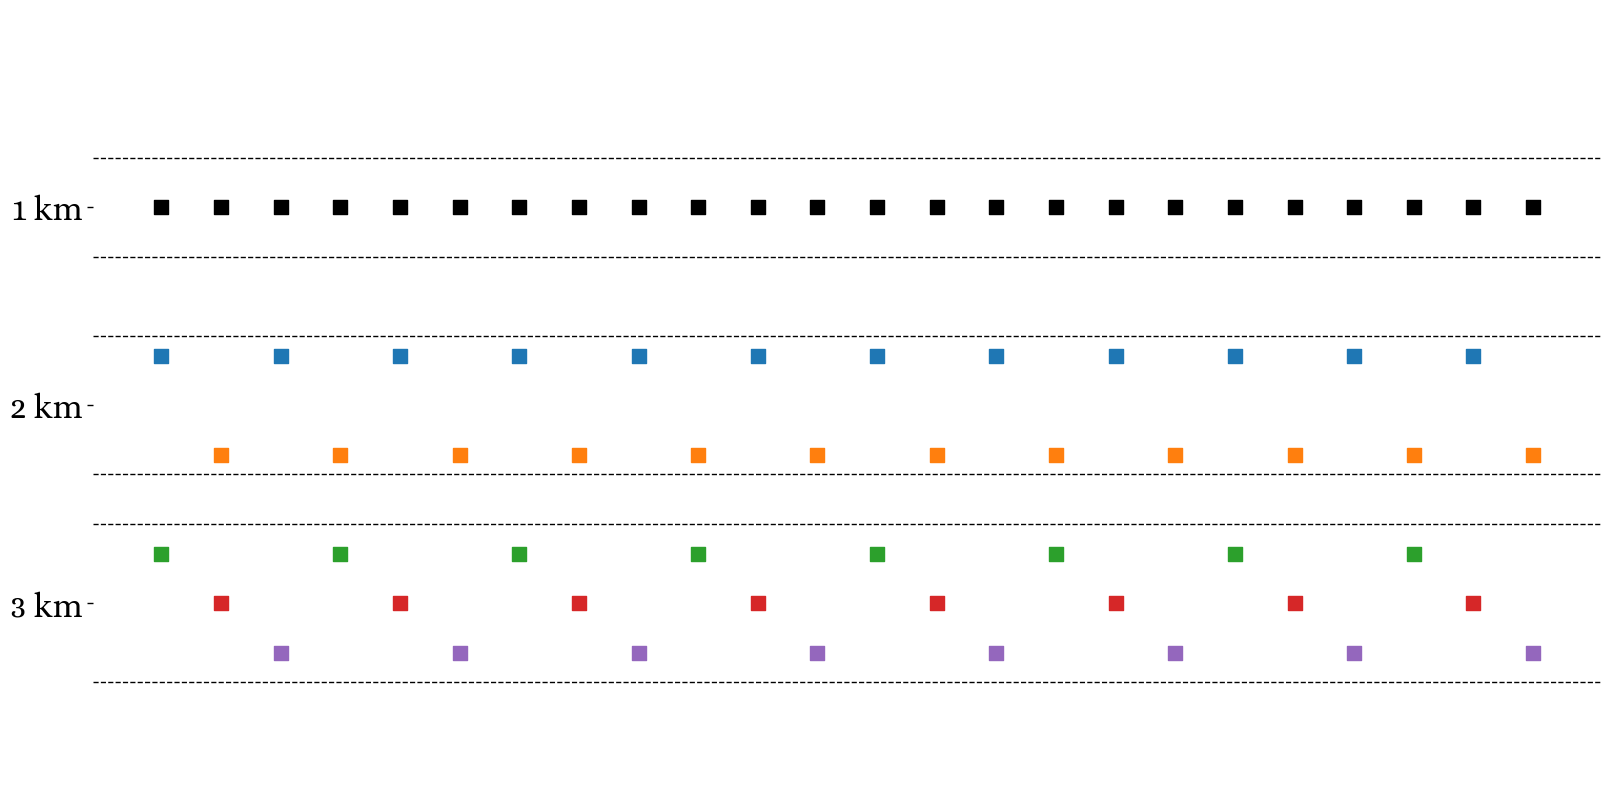

In [161]:
fig,ax = plt.subplots(figsize=(32/2,16/2),constrained_layout=True)

ax.scatter(np.arange(1,25,1),[1]*len(np.arange(1,25,1)), marker='s', c='k', s=100)
ax.axhline(1.25,lw=1,ls='--', c='k')
ax.axhline(0.75,lw=1,ls='--', c='k')

ax.scatter(np.arange(1,25,2),[1.75]*len(np.arange(1,25,2)), marker='s', c="C0", s=100)
ax.scatter(np.arange(2,25,2),[2.25]*len(np.arange(2,25,2)), marker='s', c="C1", s=100)
ax.axhline(2.35,lw=1,ls='--', c='k')
ax.axhline(1.65,lw=1,ls='--', c='k')


ax.scatter(np.arange(1,25,3),[2.75]*len(np.arange(1,25,3)), marker='s', c="C2", s=100)
ax.scatter(np.arange(2,25,3),[3]*len(np.arange(2,25,3)), marker='s', c="C3", s=100)
ax.scatter(np.arange(3,25,3),[3.25]*len(np.arange(3,25,3)), marker='s', c="C4", s=100)
ax.axhline(3.4,lw=1,ls='--', c='k')
ax.axhline(2.6,lw=1,ls='--', c='k')

ax.set(ylim=(4,0),yticks=[1,2,3], yticklabels=['1 km', '2 km', '3 km'], xticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()